In [1]:
import anndata
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import os

In [2]:
from utils import load_annotations

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data = anndata.read('data/datlinger_pp.h5ad')
data.varm['annotations'] = load_annotations(
    'data/c2.cp.reactome.v7.4.symbols.gmt',
    data.var_names,
    min_genes=13
)

In [5]:
TCR_same_genes = pd.read_csv('/homes/gws/jjanizek/ad_deep_plier/data/jurkat_count_data.csv',index_col=0)

In [6]:
from models import pmVAEModelNB

In [7]:
membership_mask = data.varm['annotations'].astype(bool).T
X_train, X_test = train_test_split(
    TCR_same_genes.values,
    test_size=0.25,
    shuffle=True,
    random_state=0,
)

In [8]:
countVAE = pmVAEModelNB(
    membership_mask.values,
    [6],
    4,
    beta=1e-5,
    terms=membership_mask.index,
    add_auxiliary_module=True,
    use_gpu=False,
)

### fit model

In [9]:
from torch.utils.data import Dataset, DataLoader
class RNASeqData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        if self.y is None and self.c is not None:
            return sample, self.c[index]
        else:
            return sample

In [10]:
train_ds = RNASeqData(X_train)
test_ds = RNASeqData(X_test)

In [11]:
countVAE.train(train_ds, test_ds, checkpoint_path='count_NBvae_with_aux.pkl',max_epochs=30)

-------- Epoch 000 --------
Epoch 000: training loss 006.9907,validation loss 010.8708
-------- Epoch 001 --------
Epoch 001: training loss 006.8188,validation loss 010.8581
-------- Epoch 002 --------
Epoch 002: training loss 006.6682,validation loss 010.8405
-------- Epoch 003 --------
Epoch 003: training loss 006.5323,validation loss 010.8188
-------- Epoch 004 --------
Epoch 004: training loss 006.3888,validation loss 010.7792
-------- Epoch 005 --------
Epoch 005: training loss 006.2683,validation loss 010.7240
-------- Epoch 006 --------
Epoch 006: training loss 006.1505,validation loss 010.6487
-------- Epoch 007 --------
Epoch 007: training loss 006.0382,validation loss 010.5711
-------- Epoch 008 --------
Epoch 008: training loss 005.9525,validation loss 010.4405
-------- Epoch 009 --------
Epoch 009: training loss 005.8660,validation loss 010.2628
-------- Epoch 010 --------
Epoch 010: training loss 005.7797,validation loss 010.0512
-------- Epoch 011 --------
Epoch 011: trai

In [12]:
ground_truth = torch.tensor(TCR_same_genes.values).float()
outs = countVAE.model(ground_truth)

In [13]:
## slice for stimulated vs non-stimulated cells
stim = np.zeros((TCR_same_genes.shape[0]))
stim[:705] = True
stim[705:] = False

stim = stim.astype('bool')

In [15]:
from pathexplainer import PathExplainerTorch
input_data = outs.z
baseline_data = torch.zeros(outs.z.shape[1])
baseline_data.requires_grad = True

In [16]:
# calc_likelihood_latent_z method from model

# def calc_likelihood_latent_z(self, x, z, c=None, **kwargs):
#     library = torch.sum(x, dim=1, keepdim=True)

#     x_ = torch.log(1.0 + x)

#     if c is not None:
#         network_input = torch.cat([x_, c], 1)
#     else:
#         network_input = x_
#     mu, logvar = self.encode(network_input, **kwargs)
#     generative_params = self.generative(z, library)
#     px_rate = generative_params["px_rate"]
#     theta = generative_params["theta"]
#     qz_m = mu
#     qz_v = torch.exp(logvar / 2)
#     nb_logits = (px_rate + 1e-4).log() - (theta + 1e-4).log()
#     log_lik = NegativeBinomial(theta, logits=nb_logits).log_prob(x).sum(dim=-1)
#     return -log_lik.mean()

def model_loss_wrapper(z):
    x = ground_truth
    return countVAE.model.calc_likelihood_latent_z(x, z)

In [18]:
explainer = PathExplainerTorch(model_loss_wrapper)
attributions = explainer.attributions(input_data,
                                      baseline=baseline_data,
                                      num_samples=200,
                                      use_expectation=False)

In [23]:
attributions.mean(0).shape

torch.Size([1368])

In [25]:
membership_mask.index

Index(['REACTOME_APOPTOSIS', 'REACTOME_HEMOSTASIS',
       'REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS',
       'REACTOME_OPIOID_SIGNALLING', 'REACTOME_CA_DEPENDENT_EVENTS',
       'REACTOME_G_PROTEIN_MEDIATED_EVENTS',
       'REACTOME_NEUROTRANSMITTER_RELEASE_CYCLE',
       'REACTOME_NEUROTRANSMITTER_RECEPTORS_AND_POSTSYNAPTIC_SIGNAL_TRANSMISSION',
       'REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES',
       'REACTOME_NEURONAL_SYSTEM',
       ...
       'REACTOME_SENSORY_PERCEPTION',
       'REACTOME_CELLULAR_RESPONSE_TO_STARVATION',
       'REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       'REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES_AND_RHOBTB3',
       'REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION',
       'REACTOME_CLASS_I_MHC_MEDIATED_ANTIGEN_PROCESSING_PRESENTATION',
       'REACTOME_KINESINS',
       'REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEVELOPMENT_AND_PLATELET_PRODUCTION',
       'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
       'REAC

In [48]:
np_attribs = attributions.detach().numpy()
top_features = pd.DataFrame(index=countVAE.latent_space_names())
top_features['loss_attrib'] = np_attribs.mean(0)

In [49]:
top_features.sort_values('loss_attrib',ascending=True).iloc[:20,:]

,loss_attrib
AUXILIARY-0,-19.178642
AUXILIARY-2,-17.483047
AUXILIARY-1,-17.473526
AUXILIARY-3,-17.028448
REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION-0,-1.990053
REACTOME_METABOLISM_OF_LIPIDS-2,-1.929796
REACTOME_METABOLISM_OF_LIPIDS-0,-1.892864
REACTOME_CELL_CYCLE-0,-1.859454
REACTOME_METABOLISM_OF_LIPIDS-3,-1.849262
REACTOME_CELLULAR_RESPONSES_TO_EXTERNAL_STIMULI-0,-1.640703


In [52]:
countVAE.latent_space_names().index('REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION-0')

796

<Figure size 432x432 with 0 Axes>

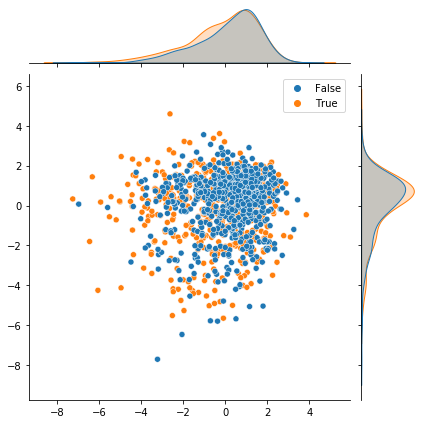

In [53]:
# scatter aux 0 and 2
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(figsize=(6,6))
sb.jointplot(x=input_data[:,164].detach().numpy(),y=input_data[:,796].detach().numpy(),hue=stim)
plt.show()